# Project Overview

Perkembangan layanan streaming video seperti Netflix, Disney+, dan Amazon Prime membuat jumlah film dan serial TV yang tersedia sangat banyak. Pengguna sering bingung memilih tontonan yang sesuai preferensi mereka. Sistem rekomendasi yang memanfaatkan rating pengguna saja terkadang kurang akurat karena bisa bias dan tidak mempertimbangkan sentimen review serta tren terkini di sosial media. Oleh karena itu, proyek ini bertujuan membangun sistem rekomendasi yang menggabungkan data rating, analisis sentimen review film/series, dan tren sosial media untuk memberikan rekomendasi yang lebih relevan dan up-to-date.

referensi:


*   [Sistem Rekomendasi Film Menggunakan Content Based Filtering](https://j-ptiik.ub.ac.id/index.php/j-ptiik/article/view/9163)
*   [Sistem Rekomendasi Film Menggunakan Metode Hybrid Collaborative Filtering Dan Content-based Filtering](https://openlibrarypublications.telkomuniversity.ac.id/index.php/engineering/article/view/18066)



# Business Understanding

## Problem Statements

1. Pengguna kesulitan memilih film yang sesuai dengan selera mereka di platform streaming.
2. Data rating saja tidak cukup untuk memberikan rekomendasi yang relevan karena bisa bias.
3. Tren sosial media belum dimanfaatkan secara maksimal dalam sistem rekomendasi.

## Goals

1. Membangun sistem rekomendasi film yang menggabungkan rating pengguna, analisis sentimen review, dan tren sosial media.
2. Memastikan rekomendasi yang diberikan lebih relevan dengan selera pengguna dan tren terkini.
3. Mengurangi bias dalam rekomendasi dengan memanfaatkan data sosial media.

## Solution Approach

1. **Content-Based Filtering**: Menggunakan informasi yang ada di film, seperti genre dan deskripsi, untuk merekomendasikan film yang serupa dengan yang sudah dilihat pengguna.
2. **Collaborative Filtering**: Menggunakan data rating dari pengguna lain untuk memberikan rekomendasi berdasarkan kesamaan preferensi antar pengguna.


# Data Understanding

Dataset yang digunakan dalam proyek ini terdiri dari 4 file utama:

1. **movies.csv** - Berisi informasi film, seperti `movieId`, `title`, dan `genres`.
2. **ratings.csv** - Berisi data rating film yang diberikan oleh pengguna, dengan kolom `userId`, `movieId`, `rating`, dan `timestamp`.
3. **tags.csv** - Berisi tag atau kata kunci yang diberikan pengguna pada film tertentu.

## Variabel/ Fitur:
- **movies.csv**:
  - `movieId`: ID unik untuk setiap film.
  - `title`: Judul film.
  - `genres`: Kategori genre yang dimiliki film, dipisah dengan tanda `|`.
- **ratings.csv**:
  - `userId`: ID unik untuk setiap pengguna.
  - `movieId`: ID film yang diberi rating oleh pengguna.
  - `rating`: Rating yang diberikan pengguna terhadap film (skala 1-5).
  - `timestamp`: Waktu pengguna memberikan rating.
- **tags.csv**:
  - `userId`: ID pengguna yang memberikan tag.
  - `movieId`: ID film yang diberi tag.
  - `tag`: Kata kunci atau tag yang diberikan pengguna.
  - `timestamp`: Waktu pemberian tag.

# Import Libary


In [ ]:
!pip install annoy

In [ ]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2463304 sha256=ac98a864e15e7875dc03884ff5507bb8f55fa91bf3d57df184693a58a39e464a
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


In [ ]:
from annoy import AnnoyIndex

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import hstack



import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

# Data Load

In [4]:
# Load dataset
movies = pd.read_csv('/content/drive/MyDrive/Coding Camp - DBS Fundation/Machine Learning Terapan/Submission Kedua/dataset/movies.csv')
ratings = pd.read_csv('/content/drive/MyDrive/Coding Camp - DBS Fundation/Machine Learning Terapan/Submission Kedua/dataset/ratings.csv')
tags = pd.read_csv('/content/drive/MyDrive/Coding Camp - DBS Fundation/Machine Learning Terapan/Submission Kedua/dataset/tags.csv')

In [ ]:
# --- Tampilkan contoh data ---
print("=== Contoh data movies.csv ===")
print(movies.head(), '\n')

print("=== Contoh data ratings.csv ===")
print(ratings.head(), '\n')

print("=== Contoh data tags.csv ===")
print(tags.head(), '\n')

=== Contoh data movies.csv ===
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy   

=== Contoh data ratings.csv ===
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931 

=== Contoh data tags.csv ===
   userId  movieId              tag   timestamp
0       2    60756            fun

# EDA (Data Exploratory Analysis)

## Movies Variable

`movies` merupakan variabel yang berisikan informasi mengenai **ID Movies, Judul Movies, Genre Movies,** serta **Tahun Tayang Movies**

In [ ]:
print(movies.head())

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


In [ ]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


`movies.info()` memberikan informasi mengenai tipe data dan jumlah data yang hilang (missing values) untuk setiap kolom.

Jumlah rom / baris data ini yaitu sebanyak **9742** data dan tidak tidak memiliki **missing value** ditunjukkan pada *non-null*

Pada dataset tersebut memiliki **2** tipe data berbentuk **object** dan **1** tipe data berbentuk **int**.

In [ ]:
movies.describe()

,movieId
count,9742.000000
mean,42200.353623
std,52160.494854
min,1.000000
25%,3248.250000
50%,7300.000000
75%,76232.000000
max,193609.000000


pada kolom `movieId` memiliki rentang nilai dengan minimal *1* dan maksimal *193609*

In [ ]:
movies.duplicated().sum()

np.int64(0)

hasil diatas menunjukkan bahwa tidak ada **data duplikat**

In [ ]:
print(f"Total movies: {movies['title'].nunique()}")

Total movies: 9737


berdasarkan informasi diatas bertujuan untuk mengetahui jumlah movies yang **unique**, yaitu terdapat 9737 Movies yang berbeda berdasarkan *title*

In [ ]:
genre_list = movies['genres'].str.split('|').explode()

print("\nTop 10 Genre Film:")
print(genre_list.value_counts().head(10))


Top 10 Genre Film:
genres
Drama        4361
Comedy       3756
Thriller     1894
Action       1828
Romance      1596
Adventure    1263
Crime        1199
Sci-Fi        980
Horror        978
Fantasy       779
Name: count, dtype: int64


berdasarkan informasi diatas , top 10 genre yang paling banyak ditampilkan :

1.   Drama dengan **4361** movie
2.   Comedy dengan **3756** movie
3.   Thriller dengan **1894** movie
4.   Action dengan **1828** movie
5.   Romance dengan **1596** movie
6.   Adventure dengan **1263** movie
7.   Crime dengan **1199** movie
8.   Sci-Fi dengan **980** movie
9.   Horror dengan **978** movie
10.  Fantasy dengan **779** movie



In [ ]:
print(f"Jumlah movieId unik di movies: {movies['movieId'].nunique()}")
print(f"Jumlah total baris di movies: {len(movies)}")

# Cek baris duplikat movieId
duplicates = movies[movies.duplicated(subset=['movieId'], keep=False)]
print("Baris duplikat berdasarkan movieId di movies:")
print(duplicates)

Jumlah movieId unik di movies: 9742
Jumlah total baris di movies: 9742
Baris duplikat berdasarkan movieId di movies:
Empty DataFrame
Columns: [movieId, title, genres]
Index: []


## Ratings Variabels

`ratings` merupakan variabel yang memberikan informasi mengenai penilaian user terkait movie yang ditonton dengan memberikan angka 1 - 5

In [ ]:
print(ratings.head())

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


`ratings.info()` menunjukkan informasi mengenai banyaknya **kolom**, **jumlah data**, **jumlah data kosong**, dan **tipe data kolom**

Hasil menunjukkan terdapat 4 kolom yaitu *userId, movieId, rating, dan timestamp*,
 yang mana 3 bertipe data
**int** (userId,movieId, dan timestamp) dan 1 **float**(rating)

In [ ]:
ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


berdasarkan informasi dari `describe()` yang memberikan informasi statistik pada masing-masing kolom numerik

`rating` merupakan penilaian terhadap suatu movie oleh user yang mana menunjukkan minimal user memberikan rating 1 dan maksimal 5 , dengan rata-rata yaitu 3.5

In [ ]:
ratings.duplicated().sum()

np.int64(0)

hasil diatas menunjukkan bahwa tidak ada **data duplikat**

In [ ]:
jumlah_user = ratings['userId'].nunique()
jumlah_movie = ratings['movieId'].nunique()

print(f"Jumlah User: {jumlah_user}")
print(f"Jumlah Movie: {jumlah_movie}")

Jumlah User: 610
Jumlah Movie: 9724


`jumlah_user` merupakan variabel yang menampung jumlah nilai unik pada kolom `userId` dengan jumlah **610** user yang sudah mengisi rating

`jumlah_movie` merupakan variabel yang menampung jumlah nilai unik pada kolom `movie` dengan jumlah **9724** movies yang sudah dinilai oleh user

In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
# cek user apakah mengisi rating movie yang sama lebih dari 1 kali
print(ratings.groupby(['userId','movieId']).size().max())

1


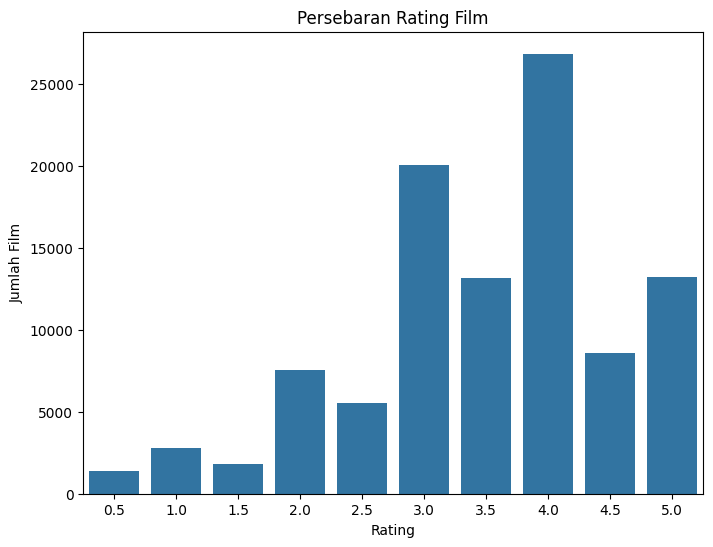

In [ ]:
# Visualisasi Persebaran berdasarkan ratings

plt.figure(figsize=(8, 6))
sns.countplot(x='rating', data=ratings)
plt.title('Persebaran Rating Film')
plt.xlabel('Rating')
plt.ylabel('Jumlah Film')
plt.show()


## Tags Variabel

`tags` merupakan variabel yang memberikan informasi mengenai penilaian *user* terhadap *movie* tentang gambaran mengenai movie tersebut.   

In [ ]:
print(tags.head())

   userId  movieId              tag   timestamp
0       2    60756            funny  1445714994
1       2    60756  Highly quotable  1445714996
2       2    60756     will ferrell  1445714992
3       2    89774     Boxing story  1445715207
4       2    89774              MMA  1445715200


In [ ]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


In [ ]:
tags.duplicated().sum()

np.int64(0)

hasil diatas menunjukkan bahwa tidak ada **data duplikat**

In [ ]:
jumlah_movie = tags['movieId'].nunique()
jumlah_user = tags['userId'].nunique()
jumlah_tag = tags['tag'].nunique()

print(f"Jumlah User: {jumlah_user}")
print(f"Jumlah Movie: {jumlah_movie}")
print(f"Jumlah Tag: {jumlah_tag}")

Jumlah User: 58
Jumlah Movie: 1572
Jumlah Tag: 1589


berdasarkan informasi diatas, jumlah user yang memberikan tags sebanyak **58** user *unik*, kemudian jumlah movie yang diberikan tags sebanyak **1572** tags, dan jumlah tags yang diberikan oleh user sebanyak **1589**   

In [ ]:
# Cek apakah user bisa menambahkan lebih dari tag pada movies yang sama
print(tags.groupby(['userId','movieId']).size().max())

173


# Data Preparation

## Movies Variable

### Memisahkan genre menjadi list

In [5]:
# Memisahkan genres kedalam daftar list

movies['genres'] = movies['genres'].str.split('|')

movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


### Memisahkan title dengan tahun rilis

In [6]:
# Memisahkan title dengan tahun rilis

movies['year'] = movies['title'].str.extract(r'\((\d{4})\)', expand=False)
movies['title'] = movies['title'].str.replace(r'\s*\(\d{4}\)', '', regex=True).str.strip()


movies.sample(10)

,movieId,title,genres,year
4389,6440,Barton Fink,"[Drama, Thriller]",1991
6530,54272,"Simpsons Movie, The","[Animation, Comedy]",2007
1529,2064,Roger & Me,[Documentary],1989
8382,109673,300: Rise of an Empire,"[Action, Drama, War, IMAX]",2014
7813,92507,Safe House,"[Action, Crime, Mystery, Thriller]",2012
123,150,Apollo 13,"[Adventure, Drama, IMAX]",1995
7961,96281,ParaNorman,"[Adventure, Animation, Comedy]",2012
2240,2975,"Best Man, The","[Comedy, Drama]",1999
865,1140,Entertaining Angels: The Dorothy Day Story,[Drama],1996
3588,4919,Subway,"[Crime, Drama, Romance, Thriller]",1985


### Memberikan nilai pada data tahun yang kosong

In [7]:
# Memberikan nilai pada data yang tidak memiliki tahun
movies['year'] = movies['year'].fillna(0).astype(int)

movies.head()

,movieId,title,genres,year
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II,[Comedy],1995


In [ ]:
movies.isna().sum()

,0
movieId,0
title,0
genres,0
year,0


## Ratings Variable

### Drop kolom timestamp

In [8]:
ratings = ratings.drop(['timestamp'], axis=1)

ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int64  
 1   movieId  100836 non-null  int64  
 2   rating   100836 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.3 MB


In [ ]:
ratings.duplicated().sum()

np.int64(0)

## Tags Variable

In [8]:
print(tags.groupby(['userId','movieId']).size().max())

173


### Menggabungkan tag yang diberikan user pada movies yang sama

In [9]:
tags_agg = tags.groupby(['userId', 'movieId'])['tag'].apply(lambda x: ','.join(x.unique())).reset_index()

tags_agg.head()

,userId,movieId,tag
0,2,60756,"funny,Highly quotable,will ferrell"
1,2,89774,"Boxing story,MMA,Tom Hardy"
2,2,106782,"drugs,Leonardo DiCaprio,Martin Scorsese"
3,7,48516,way too long
4,18,431,"Al Pacino,gangster,mafia"


In [10]:
tags_agg['tag'] = tags_agg['tag'].fillna('no_tag')

tags_agg.head()

,userId,movieId,tag
0,2,60756,"funny,Highly quotable,will ferrell"
1,2,89774,"Boxing story,MMA,Tom Hardy"
2,2,106782,"drugs,Leonardo DiCaprio,Martin Scorsese"
3,7,48516,way too long
4,18,431,"Al Pacino,gangster,mafia"


In [11]:
tags_agg = tags_agg.drop_duplicates()

tags_agg.head()

,userId,movieId,tag
0,2,60756,"funny,Highly quotable,will ferrell"
1,2,89774,"Boxing story,MMA,Tom Hardy"
2,2,106782,"drugs,Leonardo DiCaprio,Martin Scorsese"
3,7,48516,way too long
4,18,431,"Al Pacino,gangster,mafia"


In [12]:
tags_agg['tag'] = tags_agg['tag'].str.split(',')

tags_agg.head()

,userId,movieId,tag
0,2,60756,"[funny, Highly quotable, will ferrell]"
1,2,89774,"[Boxing story, MMA, Tom Hardy]"
2,2,106782,"[drugs, Leonardo DiCaprio, Martin Scorsese]"
3,7,48516,[way too long]
4,18,431,"[Al Pacino, gangster, mafia]"


## Menggabungkan Ratings dengan Tags


In [13]:
ratings_tags = pd.merge(ratings, tags_agg, on=['userId', 'movieId'], how='left')

ratings_tags.head()

,userId,movieId,rating,tag
0,1,1,4.0,NaN
1,1,3,4.0,NaN
2,1,6,4.0,NaN
3,1,47,5.0,NaN
4,1,50,5.0,NaN


In [ ]:
ratings_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int64  
 1   movieId  100836 non-null  int64  
 2   rating   100836 non-null  float64
 3   tag      1635 non-null    object 
dtypes: float64(1), int64(2), object(1)
memory usage: 3.1+ MB


In [14]:
ratings_tags['tag'] = ratings_tags['tag'].fillna('no_tag')

ratings_tags.head()

,userId,movieId,rating,tag
0,1,1,4.0,no_tag
1,1,3,4.0,no_tag
2,1,6,4.0,no_tag
3,1,47,5.0,no_tag
4,1,50,5.0,no_tag


In [ ]:
ratings_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int64  
 1   movieId  100836 non-null  int64  
 2   rating   100836 non-null  float64
 3   tag      100836 non-null  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 3.1+ MB


## Menggabungkan Seluruh Data

In [15]:
full_data = pd.merge(ratings_tags, movies, on='movieId', how='left')

full_data.head()

,userId,movieId,rating,tag,title,genres,year
0,1,1,4.0,no_tag,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,1,3,4.0,no_tag,Grumpier Old Men,"[Comedy, Romance]",1995
2,1,6,4.0,no_tag,Heat,"[Action, Crime, Thriller]",1995
3,1,47,5.0,no_tag,Seven (a.k.a. Se7en),"[Mystery, Thriller]",1995
4,1,50,5.0,no_tag,"Usual Suspects, The","[Crime, Mystery, Thriller]",1995


## Data Preparation untuk Content-Based Filtering (CBF)

### Menggabungkan Tags ke dalam satu string

In [16]:
def clean_and_join_tags(tag_lists):
    """
    Menerima Series yang berisi list tag per film dari beberapa user,
    menggabungkan tag menjadi string, dan melewati tag 'no_tag'.
    """
    cleaned_tags = []
    for tags in tag_lists:
        # Pastikan tags adalah list, jika tidak buat list kosong
        if isinstance(tags, list):
            # Filter hapus 'no_tag'
            filtered = [tag.strip() for tag in tags if tag.strip().lower() != 'no_tag']
            cleaned_tags.extend(filtered)
    # Gabungkan menjadi satu string
    if len(cleaned_tags) == 0:
        return ''  # jika tidak ada tag selain no_tag
    return ' '.join(cleaned_tags)

# Cara pakai pada dataframe full_data:
tags_per_movie = full_data.groupby('movieId')['tag'].apply(clean_and_join_tags).reset_index()

print(tags_per_movie.head())

   movieId                                           tag
0        1                               pixar pixar fun
1        2  fantasy magic board game Robin Williams game
2        3                                     moldy old
3        4                                              
4        5                              pregnancy remake


Pada fungsi diatas menggabungkan `tags` kedalam satu string yang sama jika terdapat lebih dari 1 tag pada `movie` yang sama.

### TF-IDF

In [17]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(tags_per_movie['tag'])

print(f"Shape TF-IDF matrix: {tfidf_matrix.shape}")

Shape TF-IDF matrix: (9724, 1000)


TF-IDF digunakan untuk mengubah data `tag` menjadi matriks vektor yang dapat digunakan dalam pemodelan CBF. Matriks vektor ini akan digunakan sebagai fitur atribut film dalam CBF. dengan menambahkan parameter `stop_words='english'` dan `max_features=1000` untuk menghilangkan kata-kata yang tidak memiliki makna dan mengambil 1000 fitur tertinggi.

## Data Preparation untuk Collaboration Filtering (CF)

In [16]:
df_rating = ratings

df_rating.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [ ]:
df_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int64  
 1   movieId  100836 non-null  int64  
 2   rating   100836 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.3 MB


#### Mengacak Data

In [17]:
# Mengacak dataset
df_rating = df_rating.sample(frac=1, random_state=42)
df_rating

,userId,movieId,rating
67037,432,77866,4.5
42175,288,474,3.0
93850,599,4351,3.0
6187,42,2987,4.0
12229,75,1610,4.0
...,...,...,...
6265,42,4005,4.0
54886,364,141,4.0
76820,480,6867,4.0
860,6,981,3.0


#### Split Data

In [18]:
min_rating = df_rating['rating'].min()
max_rating = df_rating['rating'].max()

# Membuat variabel x untuk mencocokkan data user dan movie menjadi satu value
x = df_rating[['userId', 'movieId']].values

# Membuat variabel y untuk membuat rating dari hasil
y = df_rating['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * df_rating.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[  432 77866]
 [  288   474]
 [  599  4351]
 ...
 [  480  6867]
 [    6   981]
 [  103  6711]] [0.88888889 0.55555556 0.55555556 ... 0.77777778 0.55555556 1.        ]


#### Mapping Data

In [19]:
# Mapping userId dan movieId ke indeks embedding
user_ids = df_rating['userId'].unique().tolist()
user_to_index = {user_id: index for index, user_id in enumerate(user_ids)}
index_to_user = {index: user_id for index, user_id in enumerate(user_ids)}

movie_ids = df_rating['movieId'].unique().tolist()
movie_to_index = {movie_id: index for index, movie_id in enumerate(movie_ids)}
index_to_movie = {index: movie_id for index, movie_id in enumerate(movie_ids)}

# Terapkan mapping ke data training dan validasi
x_train[:, 0] = [user_to_index[user_id] for user_id in x_train[:, 0]]
x_val[:, 0] = [user_to_index[user_id] for user_id in x_val[:, 0]]

x_train[:, 1] = [movie_to_index[movie_id] for movie_id in x_train[:, 1]]
x_val[:, 1] = [movie_to_index[movie_id] for movie_id in x_val[:, 1]]

# The number of unique users and movies should be based on the number of unique entries in the original data
num_users = len(user_ids)
num_movies = len(movie_ids)

# Modelling


## Content-Based Filtering

### Cosine Similarity

In [18]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
print(f"Shape cosine similarity matrix: {cosine_sim.shape}")

Shape cosine similarity matrix: (9724, 9724)


Menghitung Cosine Similarity antara setiap baris (movie) dalam matrix TF-IDF. Cosine Similarity digunakan untuk mengukur kemiripan antara dua vektor. Dalam konteks ini, kita ingin menemukan movie yang mirip dengan movie lainnya berdasarkan *tags* mereka.

Cosine Similarity mengukur kemiripan antara dua vektor berdasarkan sudut (bukan panjangnya).

Nilai berada di antara `-1` hingga `1`:

`1` → sangat mirip (arah vektor sama)

`0` → tidak mirip (tegak lurus)

`-1` → berlawanan (jarang terjadi di NLP)

**Rumus Cosine Similarity**

$$
\text{cosine_similarity}(A, B) = \frac{A \cdot B}{\|A\| \times \|B\|}
$$

Keterangan:
- $ A \cdot B $: dot product antara vektor A dan B  
- $ \|A\| $: panjang (norma) dari vektor A  
- $ \|B\| $: panjang (norma) dari vektor B

### Inferensi

In [19]:
def get_recommendations_by_tag(movie_id, top_n=5):
    # Cari indeks film
    idx = tags_per_movie[tags_per_movie['movieId'] == movie_id].index[0]

    # Hitung similarity film lain
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Urutkan berdasarkan similarity tertinggi
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Ambil top-n film paling mirip, kecuali film itu sendiri
    sim_scores = sim_scores[1:top_n+1]

    # Ambil indeks film rekomendasi
    movie_indices = [i[0] for i in sim_scores]

    # Ambil movieId dan judul film dari dataframe movies (yang sudah kamu siapkan)
    recommended_ids = tags_per_movie.iloc[movie_indices]['movieId'].values
    recommended_movies = movies[movies['movieId'].isin(recommended_ids)][['movieId', 'title']].drop_duplicates()

    return recommended_movies


def recommend_by_title_tag():
    movie_name = input("Masukkan judul film: ").strip().lower()

    # Cari movieId berdasarkan judul (case insensitive)
    matched = movies[movies['title'].str.lower() == movie_name]

    if matched.empty:
        print(f"Film dengan judul '{movie_name}' tidak ditemukan. Coba lagi.")
        return

    movie_id = matched.iloc[0]['movieId']
    print(f"Film yang dipilih: {matched.iloc[0]['title']}")

    recommendations = get_recommendations_by_tag(movie_id)

    if recommendations.empty:
        print("Tidak ada rekomendasi yang tersedia.")
    else:
        print("Rekomendasi film serupa berdasarkan tag:")
        for idx, row in recommendations.iterrows():
            print(f"- {row['title']} (movieId: {row['movieId']})")

In [20]:
# Jalankan fungsi input rekomendasi
recommend_by_title_tag()

Masukkan judul film: Godzilla
Film yang dipilih: Godzilla
Rekomendasi film serupa berdasarkan tag:
- Jumanji (movieId: 2)
- Grumpier Old Men (movieId: 3)
- Waiting to Exhale (movieId: 4)
- Father of the Bride Part II (movieId: 5)
- Heat (movieId: 6)


## Collaborative Filterring


### Proses Training

In [20]:
class RecommenderNet(tf.keras.Model):

  # Insialisasi fungsi
  def __init__(self, num_users, num_movies, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_movies = num_movies
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.movies_embedding = layers.Embedding( # layer embeddings movies
        num_movies,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.movies_bias = layers.Embedding(num_movies, 1) # layer embedding movies bias

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    movies_vector = self.movies_embedding(inputs[:, 1]) # memanggil layer embedding 3
    movies_bias = self.movies_bias(inputs[:, 1]) # memanggil layer embedding 4

    dot_user_movies = tf.tensordot(user_vector, movies_vector, 2)

    x = dot_user_movies + user_bias + movies_bias

    return tf.nn.sigmoid(x) # activation sigmoid

Data userId dan movieId diubah menjadi indeks numerik agar dapat digunakan sebagai input embedding pada model neural network.

In [21]:
model = RecommenderNet(num_users, num_movies, 50) # inisialisasi model

earlystopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) # inisialisasi earlystopping

checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True) # inisialisasi checkpoint

# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]

)

In [22]:
# Memulai training

history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    epochs = 100,
    callbacks = [earlystopping, checkpoint],
    validation_data = (x_val, y_val)
)

Epoch 1/100
10084/10084 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6452 - root_mean_squared_error: 0.2401

10084/10084 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - loss: 0.6452 - root_mean_squared_error: 0.2401 - val_loss: 0.6128 - val_root_mean_squared_error: 0.2062
Epoch 2/100
10068/10084 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6052 - root_mean_squared_error: 0.1996

10084/10084 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - loss: 0.6052 - root_mean_squared_error: 0.1996 - val_loss: 0.6089 - val_root_mean_squared_error: 0.2017
Epoch 3/100
10080/10084 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6012 - root_mean_squared_error: 0.1931

10084/10084 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 0.6012 - root_mean_squared_error: 0.1931 - val_loss: 0.6076 - val_root_mean_squared_error: 0.2001
Epoch 4/100
10073/10084 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5968 - root_mean_squared_error: 0.1901

10084/10084 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - loss: 0.5968 - root_mean_squared_error: 0.1901 - val_loss: 0.6068 - val_root_mean_squared_error: 0.1992
Epoch 5/100
10064/10084 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5963 - root_mean_squared_error: 0.1882

10084/10084 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 0.5963 - root_mean_squared_error: 0.1882 - val_loss: 0.6061 - val_root_mean_squared_error: 0.1982
Epoch 6/100
10084/10084 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - loss: 0.5935 - root_mean_squared_error: 0.1856 - val_loss: 0.6062 - val_root_mean_squared_error: 0.1983
Epoch 7/100
10084/10084 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 0.5944 - root_mean_squared_error: 0.1846 - val_loss: 0.6063 - val_root_mean_squared_error: 0.1983
Epoch 8/100
10084/10084 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 0.5937 - root_mean_squared_error: 0.1838 - val_loss: 0.6065 - val_root_mean_squared_error: 0.1983


Model dilatih dengan optimasi binary crossentropy dan menggunakan root mean squared error (RMSE) sebagai metrik evaluasi. Early stopping dan checkpoint digunakan untuk mencegah overfitting dan menyimpan model terbaik.

### Visualisasi Metrik

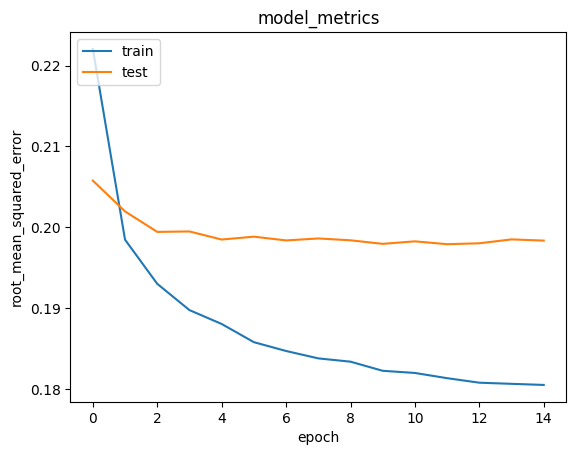

In [ ]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Grafik ini menunjukkan perkembangan performa model selama training. RMSE yang menurun menandakan model semakin baik dalam memprediksi rating.

### Inferensi

In [ ]:
def get_collaborative_recommendations(user_id, top_n=5):
      # Cek apakah user_id ada di mapping
      if user_id not in user_to_index:
          print(f"UserId {user_id} tidak ditemukan.")
          return None

      user_idx = user_to_index[user_id]

      # Semua movie index
      all_movie_indices = list(range(num_movies))

      # Movie yang sudah dirating user
      rated_movie_ids = df_rating[df_rating['userId'] == user_id]['movieId'].unique()
      rated_movie_indices = [movie_to_index[movie_id] for movie_id in rated_movie_ids if movie_id in movie_to_index]

      # Movie yang belum dirating user
      unrated_movie_indices = [i for i in all_movie_indices if i not in rated_movie_indices]

      # Prediksi rating untuk film belum dirating user
      predictions = []
      batch_size = 1000  # untuk efisiensi, prediksi batch

      for start in range(0, len(unrated_movie_indices), batch_size):
          end = min(start + batch_size, len(unrated_movie_indices))
          batch_movie_indices = unrated_movie_indices[start:end]
          batch_user_indices = [user_idx] * len(batch_movie_indices)

          inputs = np.array([batch_user_indices, batch_movie_indices]).T
          preds = model.predict(inputs).flatten()

          for movie_idx, pred_rating in zip(batch_movie_indices, preds):
              predictions.append((movie_idx, pred_rating))

      # Urutkan berdasarkan prediksi rating tertinggi
      predictions.sort(key=lambda x: x[1], reverse=True)

      # Ambil top_n rekomendasi
      top_predictions = predictions[:top_n]

      # Ambil movieId dari index
      recommended_movie_ids = [index_to_movie[movie_idx] for movie_idx, _ in top_predictions]

      # Ambil judul film dari dataframe movies
      recommended_movies = movies[movies['movieId'].isin(recommended_movie_ids)][['movieId', 'title', 'year']].drop_duplicates()

      return recommended_movies

In [ ]:
def recommend_collaborative():
    user_id_input = input("Masukkan userId untuk mendapatkan rekomendasi: ").strip()

    # Coba konversi input ke int, jika gagal langsung return error
    try:
        user_id = int(user_id_input)
    except ValueError:
        print("Input userId harus berupa angka.")
        return

    # Cek apakah user_id ada di data
    if user_id not in user_to_index:
        print(f"UserId {user_id} tidak ditemukan dalam data.")
        return

    recommendations = get_collaborative_recommendations(user_id, top_n=5)

    if recommendations is not None and not recommendations.empty:
        print(f"Rekomendasi film untuk userId {user_id}:")
        for _, row in recommendations.iterrows():
            print(f"- {row['title']} {row['year']} (movieId: {row['movieId']})")
    else:
        print(f"Tidak ada rekomendasi yang ditemukan untuk userId {user_id}.")


In [ ]:
df_rating.head()

,userId,movieId,rating
67037,432,77866,4.5
42175,288,474,3.0
93850,599,4351,3.0
6187,42,2987,4.0
12229,75,1610,4.0


In [ ]:
# Jalankan fungsi input interaktif
recommend_collaborative()

Masukkan userId untuk mendapatkan rekomendasi: 42
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Rekomendasi film untuk userId 42:
- Cinema Paradiso (Nuovo cinema Paradiso) 1989 (movieId: 1172)
- Third Man, The 1949 (movieId: 1212)
- Ran 1985 (movieId: 1217)
- Big Lebowski, The 1998 (movieId: 1732)
- Lord of the Rings: The Fellowship of the Ring, The 2001 (movieId: 4993)


## Evaluasi

### Content-Based Filtering

#### Precision

**Precision@5** mengukur seberapa banyak rekomendasi yang relevan di antara 5 rekomendasi teratas yang diberikan oleh sistem. Dengan nilai **0.2000**, artinya **20%** dari rekomendasi teratas adalah relevan, sementara sisanya tidak relevan.


Formula Precision@5:

$$
\text{Precision@5} = \frac{\text{Jumlah rekomendasi relevan}}{5}
$$


In [27]:
# Fungsi untuk menghitung Precision@K
def evaluate_precision_at_k(user_id, movie_id, top_n=5):
    recommended_movies = get_recommendations_by_tag(movie_id, top_n)

    # Ambil film yang disukai oleh pengguna (relevan)
    liked_movies = full_data[full_data['userId'] == user_id]['movieId'].tolist()

    # Hitung berapa banyak rekomendasi yang relevan
    relevant_movies = [movie for movie in recommended_movies['movieId'] if movie in liked_movies]

    precision_at_k = len(relevant_movies) / top_n
    print(f"Precision@{top_n}: {precision_at_k:.4f}")
    return precision_at_k

#### Recall

**Recall@K** mengukur seberapa banyak **rekomendasi relevan** yang berhasil ditemukan oleh model dari seluruh **film relevan yang disukai oleh pengguna**. Dengan kata lain, Recall mengukur kemampuan model dalam **menemukan** film relevan yang seharusnya ditampilkan kepada pengguna.

$$
\text{Recall@K} = \frac{\text{Jumlah rekomendasi relevan}}{\text{Jumlah film relevan yang disukai pengguna}}
$$

In [28]:
# Fungsi untuk menghitung Recall@K
def evaluate_recall_at_k(user_id, movie_id, top_n=5):
    recommended_movies = get_recommendations_by_tag(movie_id, top_n)

    # Ambil film yang disukai oleh pengguna (relevan)
    liked_movies = full_data[full_data['userId'] == user_id]['movieId'].tolist()

    # Hitung berapa banyak rekomendasi relevan yang ditemukan
    relevant_movies = [movie for movie in recommended_movies['movieId'] if movie in liked_movies]

    recall_at_k = len(relevant_movies) / len(liked_movies)
    print(f"Recall@{top_n}: {recall_at_k:.4f}")
    return recall_at_k

#### F1-Score

**F1-Score** adalah rata-rata harmonis antara **Precision** dan **Recall**. F1-Score memberikan gambaran yang lebih seimbang antara kemampuan model untuk memberikan rekomendasi relevan (Precision) dan kemampuan model untuk menemukan semua rekomendasi relevan yang ada (Recall).

Formula:
$$
\text{F1-SCORE} = 2\frac{\text{Precision x Recall}}{\text{Precision + Recall}}
$$

In [34]:
def evaluate_f1_score(user_id, movie_id, top_n=5):
    recommended_movies = get_recommendations_by_tag(movie_id, top_n)

    # Ambil film yang disukai oleh pengguna (relevan)
    liked_movies = full_data[full_data['userId'] == user_id]['movieId'].tolist()

    # Tentukan relevansi rekomendasi (1 = relevan, 0 = tidak relevan)
    relevant_movies = [1 if movie in liked_movies else 0 for movie in recommended_movies['movieId']]

    # Sesuaikan panjang antara relevant_movies dan true_labels (film relevan yang disukai)
    true_labels = [1] * len(relevant_movies)  # Semua film yang relevan adalah label 1

    # Pastikan panjangnya sama dengan rekomendasi yang ada
    true_labels = true_labels[:len(relevant_movies)]

    f1 = f1_score(true_labels, relevant_movies, average='micro')
    print(f"F1-Score@{top_n}: {f1:.4f}")
    return f1

#### Hasil

In [31]:
full_data.head()

,userId,movieId,rating,tag,title,genres,year
0,1,1,4.0,no_tag,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,1,3,4.0,no_tag,Grumpier Old Men,"[Comedy, Romance]",1995
2,1,6,4.0,no_tag,Heat,"[Action, Crime, Thriller]",1995
3,1,47,5.0,no_tag,Seven (a.k.a. Se7en),"[Mystery, Thriller]",1995
4,1,50,5.0,no_tag,"Usual Suspects, The","[Crime, Mystery, Thriller]",1995


In [35]:
user_id_test = 1
movie_id_test = 47

# Evaluasi Precision@5
evaluate_precision_at_k(user_id_test, movie_id_test, top_n=5)

# Evaluasi Recall@5
evaluate_recall_at_k(user_id_test, movie_id_test, top_n=5)

# Evaluasi F1-Score@5
evaluate_f1_score(user_id_test, movie_id_test, top_n=5)

Precision@5: 0.2000
Recall@5: 0.0043
F1-Score@5: 0.2000


0.2

Hasil evaluasi yang kamu tunjukkan menunjukkan bahwa Precision@5, Recall@5, dan F1-Score@5 memiliki nilai yang relatif rendah, yang mengindikasikan bahwa sistem rekomendasi berbasis Content-Based Filtering (CBF) yang menggunakan tag masih perlu diperbaiki karena tag yang yang diberikan pada user masih sedikit dan banyak movie yang tidak terdapat tag.

### Collaborative Filtering

#### RMSE pada Data Test

In [23]:
# Fungsi untuk evaluasi Collaborative Filtering dengan RMSE
def evaluate_cf_model(model, x_test, y_test):
    # Prediksi rating untuk data testing
    y_pred = model.predict(x_test)

    # Hitung RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"RMSE pada data testing: {rmse:.4f}")
    return rmse

# Evaluasi model Collaborative Filtering
evaluate_cf_model(model, x_val, y_val)

631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
RMSE pada data testing: 0.2298


np.float64(0.22977357801815934)

#### RMSE pada Data Training

In [24]:
# Prediksi pada data training
train_pred = model.predict(x_train)

# Hitung RMSE untuk data training
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))

print(f"RMSE pada data training: {train_rmse:.4f}")


2521/2521 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
RMSE pada data training: 0.2459


Perbedaan RMSE antara data training **(0.2459**)** dan data testing **(0.2298)** menunjukkan bahwa model memiliki sedikit overfitting, karena RMSE pada data testing lebih kecil daripada pada data training. Ini bisa berarti model telah terlatih dengan sangat baik pada data training, tetapi sedikit lebih kesulitan dalam menggeneralisasi pada data baru.